In [14]:
import numpy as np
import matplotlib.pyplot as plt

import ot

# I don't know how else to import functions from src
import sys, os
sys.path.insert(0, os.path.dirname((os.path.abspath("."))))

from src.sinkhorn import sinkhorn_knopp
del sys.path[0]

from sklearn.cluster import KMeans
import cv2

In [15]:
def color_clustering(im, n_clust=30):
    # https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
    im_flatten = im.reshape((-1, 3))
    clt = KMeans(n_clusters=n_clust)
    clt.fit(im_flatten)

    def _centroid_histogram(clt):
        numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
        (hist, _) = np.histogram(clt.labels_, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        return hist
    
    hist = _centroid_histogram(clt)
    colors = clt.cluster_centers_

    return hist, colors, clt.labels_

def transport(target_image, sourse_colors, target_colors, target_clusters, transportation_plan):
    """
    Transforms target image, transporting sourse color from sourse clusters according to the transportation plan.
    """
    col_normalized = transportation_plan.T / np.sum(transportation_plan, 0)[:, None]
    col_normalized[~ np.isfinite(col_normalized)] = 0
    im_transp = ((col_normalized @ sourse_colors)[target_clusters, :] + target_image.reshape((-1, 3)) - target_colors[target_clusters, :])
    im_transp = im_transp.reshape(target_image.shape)

    return im_transp

def preprocessing(image1, image2, n_clust=30):
    """
    Takes images as an input, returns supply + coordinates, demand + coordinates and cost matrix.
    """
    
    hist1, colors1, _ = color_clustering(image1, n_clust)
    hist2, colors2, clusters2 = color_clustering(image2, n_clust)
    cost = np.zeros((n_clust, n_clust))
    for i in range(n_clust):
        for j in range(n_clust):
            cost[i, j] = np.linalg.norm(colors1[i] - colors2[j])
    return hist1, colors1, hist2, colors2, clusters2, cost

In [34]:
def do_work(a, b, cost_matrix, algorithm, reg=0.01):
    """
    This thing is expected to be tested - that's where our implementation differs from default.
    """
    if algorithm == "default":
         method = lambda x,y,z: ot.sinkhorn(x,y,z,reg=reg)
    elif algorithm == "kuznedelev":
        method = lambda x,y,z: sinkhorn_knopp(a=x, b=y, C=z, reg=reg)
    else:
        raise NotImplementedError(f"We don't have an algorithm {algorithm} implemented.")
    transportation_plan = method(a, b, cost_matrix)
    return transportation_plan


def comparator_by_image_size(image1, image2, sizepoints=20):
    """
    Performs color transfering on increasingly large upper left corners of images, ending with the full images. 
    Measures time spent on color transferring and plots a plot
    """
    x1, y1 = image1.shape[:2]
    x2, y2 = image2.shape[:2]
    x_max, y_max = min(x1, x2), min(y1, y2)
    default_implementation, kuznedelev_implementation = [], []
    xx, yy = [int(el) for el in np.linspace(10, x_max, sizepoints)], [int(el) for el in np.linspace(10, y_max, sizepoints)]
    for x, y in zip(xx, yy):
        im1, im2 = image1[:x, :y, :], image2[:x, :y, :]
        hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(im1, im2)
        time = %timeit -o image = do_work(hist1, hist2, cost, "default")
        default_implementation.append(time.average)
        time = %timeit -o image = do_work(hist1, hist2, cost, "kuznedelev")
        kuznedelev_implementation.append(time.average)
    
    # Plotting
    sizes = np.array(xx)*np.array(yy) 
    plt.semilogy(sizes, default_implementation, marker="*", label="default")
    plt.semilogy(sizes, kuznedelev_implementation, marker="*", label="custom")
    plt.legend()
    plt.xlabel("Size of an image, pixels")
    plt.ylabel("Computation time, seconds")
    plt.savefig("performance_on_different_image_sizes.png")


def show_transfer_by_different_implementations(image1, image2, reg=0.01, n_clusters = 30):

    hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(image1, image2, n_clusters)
    
    transportation_plan_default = do_work(hist1, hist2, cost, "default", reg)
    transportation_plan_kuznedelev = do_work(hist1, hist2, cost, "kuznedelev", reg)
    
    transformed_by_default_implementation = transport(I2, colors1, colors2, clusters2, transportation_plan_default)
    transformed_by_kuznedelev_implementation = transport(I2, colors1, colors2, clusters2, transportation_plan_kuznedelev)
    
            
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # Removing axes
    for i in range(len(ax)):
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    
    # Plotting
    ax[0].imshow(transformed_by_default_implementation)
    ax[1].imshow(transformed_by_kuznedelev_implementation)
    
    ax[0].set_title("Default")
    ax[1].set_title("Custom")

# Tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


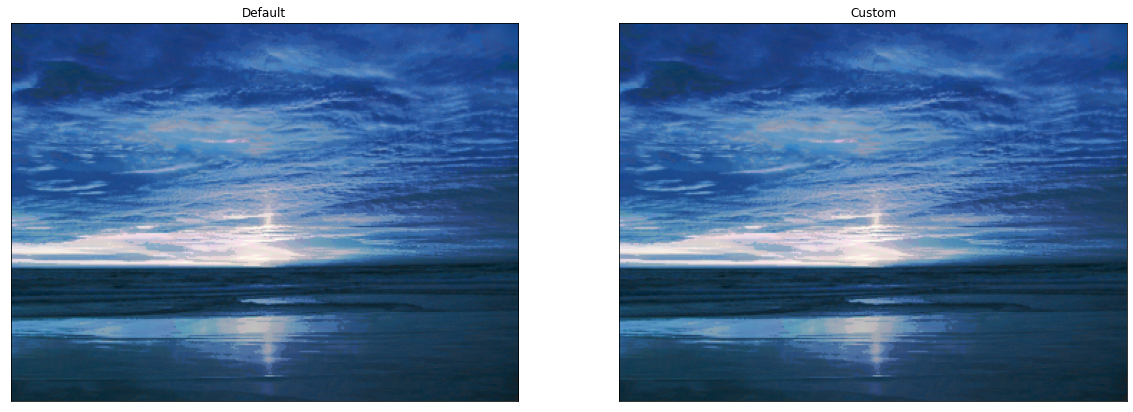

In [40]:
#I1 = plt.imread('../images/ocean_daylight.png').astype(np.float64)[:, :, :3]
#I2 = plt.imread('../images/ocean_sunset.png').astype(np.float64)[:, :, :3]
show_transfer_by_different_implementations(I1, I2, n_clusters = 50, reg = 1e-3)

In [30]:
num_clusters = 2 ** np.arange(5, 10)
reg = 1e-1

t1, t1_err = [], []
t2, t2_err = [], []

for n in num_clusters:
    hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(I1, I2, n_clust=n)
    
    transportation_plan_1 = do_work(hist1, hist2, cost, "default", reg)
    transportation_plan_2 = do_work(hist1, hist2, cost, "kuznedelev", reg)
    
    t = %timeit -o image = do_work(hist1, hist2, cost, "default")
    t1.append(t.average)
    t1_err.append(t.stdev)
    t = %timeit -o image = do_work(hist1, hist2, cost, "kuznedelev")
    t2.append(t.average)
    t2_err.append(t.stdev)

5.5 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.53 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.74 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.07 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 7.73 times longer than the fastest. This could mean that an intermediate result is being cached.
171 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
38.7 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


The slowest run took 11.14 times longer than the fastest. This could mean that an intermediate result is being cached.
114 ms ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
63.6 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
164 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Compiler time: 0.21 s
95.1 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
 hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(I1, I2, n_clust=128)

336 µs ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
281 µs ± 1.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
335 µs ± 5.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
391 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
540 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
397 µs ± 5.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
853 µs ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
685 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
903 µs ± 55.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
743 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.51 ms ± 457 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.3 ms ± 48.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.14 ms ± 750 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.84 ms ± 7.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops e

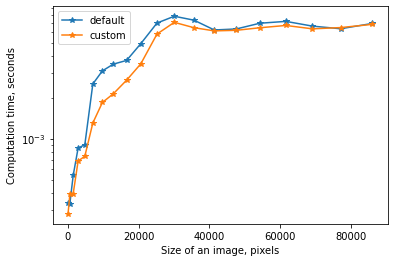

In [35]:
comparator_by_image_size(I1, I2)